In [ ]:
# ================================
#  Environment setup (Colab)
# ================================
!pip -q install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121
!pip -q install torch-geometric torch-scatter torch-sparse torch-cluster -f https://data.pyg.org/whl/torch-2.3.0+cu121.html
print("✅ PyTorch & PyG install attempted.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.3 MB/s eta 0:00:00
✅ PyTorch & PyG install attempted.


In [ ]:
# ================================
# Imports & Utilities
# ================================
import os, random, copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.metrics import roc_auc_score, average_precision_score

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, SAGEConv
from torch_geometric.utils import to_undirected, subgraph, negative_sampling, train_test_split_edges

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

/usr/local/lib/python3.12/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.12/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.12/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN5torch3ji

Device: cuda


In [ ]:
# ================================
#  Load Cora + Link Prediction Split (7/1/2)
# ================================
dataset = Planetoid(root='/content/data/Cora', name='Cora')
data = dataset[0]
data.edge_index = to_undirected(data.edge_index)

# Custom train/val/test split for link prediction following paper's 7/1/2 ratio
def make_link_split(data, train_ratio=0.7, val_ratio=0.1, seed=1):
    """
    Paper methodology: Split edges into train/val/test with 7/1/2 ratio
    Train edges used for training, val for hyperparameter tuning, test for evaluation
    """
    torch.manual_seed(seed)
    num_edges = data.edge_index.size(1) // 2  # undirected edges
    num_train = int(num_edges * train_ratio)
    num_val = int(num_edges * val_ratio)

    # Use PyG's train_test_split_edges but customize ratios
    split_data = train_test_split_edges(data, val_ratio=val_ratio, test_ratio=1-train_ratio-val_ratio)
    return split_data

data = make_link_split(data, 0.7, 0.1, seed=1)

num_feats = dataset.num_node_features
num_nodes = data.num_nodes
print(f"Nodes: {num_nodes}, Features: {num_feats}")
print(f"Train edges: {data.train_pos_edge_index.size(1)}")
print(f"Val edges: {data.val_pos_edge_index.size(1)}")
print(f"Test edges: {data.test_pos_edge_index.size(1)}")

Processing...
Done!
/usr/local/lib/python3.12/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Nodes: 2708, Features: 1433
Train edges: 7392
Val edges: 527
Test edges: 1055


In [ ]:
# ================================
#  Config for Link Prediction (paper-based)
# ================================
CFG = dict(
    # Model pools (paper uses 200 each)
    POS_TRAIN=50, POS_TEST=50,
    NEG_TRAIN=50, NEG_TEST=50,

    # Obfuscation techniques (paper methodology)
    USE_FT_LAST=True, USE_FT_ALL=True,
    USE_PR_LAST=True, USE_PR_ALL=True,
    USE_DISTILL=True,
    DISTILL_STEPS=250,   # paper uses ~1000

    # Fingerprint parameters (edge-level task specific)
    FP_P=64,                    # number of fingerprint graphs
    FP_NODES=32,                # nodes per fingerprint graph
    FP_SAMPLE_M=32,             # sample m node pairs for edge predictions
    FP_EDGE_INIT_P=0.05,        # initial edge probability
    FP_EDGE_TOPK=96,            # top-k edges to flip
    EDGE_LOGIT_STEP=2.5,        # edge update step size

    # Joint learning parameters
    OUTER_ITERS=20,
    FP_STEPS=5,                 # fingerprint update steps
    V_STEPS=10,                 # verifier update steps

    # Learning rates
    LR_TARGET=0.005,
    WD_TARGET=5e-4,
    LR_V=1e-3,
    LR_X=1e-3,

    SEED=1,
)
print("Config for Link Prediction:", CFG)


Config for Link Prediction: {'POS_TRAIN': 50, 'POS_TEST': 50, 'NEG_TRAIN': 50, 'NEG_TEST': 50, 'USE_FT_LAST': True, 'USE_FT_ALL': True, 'USE_PR_LAST': True, 'USE_PR_ALL': True, 'USE_DISTILL': True, 'DISTILL_STEPS': 250, 'FP_P': 64, 'FP_NODES': 32, 'FP_SAMPLE_M': 32, 'FP_EDGE_INIT_P': 0.05, 'FP_EDGE_TOPK': 96, 'EDGE_LOGIT_STEP': 2.5, 'OUTER_ITERS': 20, 'FP_STEPS': 5, 'V_STEPS': 10, 'LR_TARGET': 0.005, 'WD_TARGET': 0.0005, 'LR_V': 0.001, 'LR_X': 0.001, 'SEED': 1}


In [ ]:
# ================================
#  Define GNN models for Link Prediction
# ================================
class GCN_LinkPred(nn.Module):
    """GCN for link prediction - outputs node embeddings"""
    def __init__(self, in_channels, hidden, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        self.conv3 = GCNConv(hidden, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        return x  # node embeddings

    def decode(self, z, pos_edge_index, neg_edge_index=None):
        """Decode embeddings to edge probabilities using dot product"""
        edge_index = pos_edge_index if neg_edge_index is None else torch.cat([pos_edge_index, neg_edge_index], dim=-1)
        row, col = edge_index
        return (z[row] * z[col]).sum(dim=-1)  # dot product

class GraphSAGE_LinkPred(nn.Module):
    """GraphSAGE for link prediction"""
    def __init__(self, in_channels, hidden, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden)
        self.conv2 = SAGEConv(hidden, hidden)
        self.conv3 = SAGEConv(hidden, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        return x

    def decode(self, z, pos_edge_index, neg_edge_index=None):
        edge_index = pos_edge_index if neg_edge_index is None else torch.cat([pos_edge_index, neg_edge_index], dim=-1)
        row, col = edge_index
        return (z[row] * z[col]).sum(dim=-1)

In [ ]:
# ================================
#  Training helpers for Link Prediction
# ================================
@torch.no_grad()
def evaluate_link_pred(model, data):
    """Evaluate link prediction performance"""
    model.eval()
    z = model(data.x, data.train_pos_edge_index)

    # Positive and negative edges for validation
    pos_pred = model.decode(z, data.val_pos_edge_index).sigmoid()
    neg_pred = model.decode(z, data.val_neg_edge_index).sigmoid()

    y_true = torch.cat([torch.ones(pos_pred.size(0)), torch.zeros(neg_pred.size(0))], dim=0)
    y_pred = torch.cat([pos_pred, neg_pred], dim=0).cpu()

    auc = roc_auc_score(y_true.cpu(), y_pred)
    ap = average_precision_score(y_true.cpu(), y_pred)

    return auc, ap

def train_link_predictor(model, data, epochs=200, lr=0.005, wd=5e-4):
    """Train link prediction model following paper methodology"""
    model = model.to(device)
    data = data.to(device)
    opt = Adam(model.parameters(), lr=lr, weight_decay=wd)

    best = {'auc': 0.0, 'state': None}

    for ep in range(epochs):
        model.train()
        opt.zero_grad()

        # Forward pass
        z = model(data.x, data.train_pos_edge_index)

        # Negative sampling for training
        neg_edge_index = negative_sampling(
            data.train_pos_edge_index, data.num_nodes,
            num_neg_samples=data.train_pos_edge_index.size(1)
        ).to(device)

        # Decode positive and negative edges
        pos_pred = model.decode(z, data.train_pos_edge_index).sigmoid()
        neg_pred = model.decode(z, neg_edge_index).sigmoid()

        # Binary cross-entropy loss
        pos_loss = F.binary_cross_entropy(pos_pred, torch.ones_like(pos_pred))
        neg_loss = F.binary_cross_entropy(neg_pred, torch.zeros_like(neg_pred))
        loss = pos_loss + neg_loss

        loss.backward()
        opt.step()

        # Evaluate
        if ep % 10 == 0:
            auc, ap = evaluate_link_pred(model, data)
            if auc > best['auc']:
                best['auc'] = auc
                best['state'] = copy.deepcopy(model.state_dict())
            print(f"Epoch {ep:03d} | loss {loss.item():.4f} | AUC {auc:.3f} | AP {ap:.3f}")

    # Load best model
    if best['state'] is not None:
        model.load_state_dict(best['state'])

    auc, ap = evaluate_link_pred(model, data)
    print(f"✅ Final (best-val) | AUC {auc:.3f} | AP {ap:.3f}")
    return model

In [ ]:
# ================================
# Train target model f (GCN for Link Prediction)
# ================================
set_seed(CFG["SEED"])
model_f = GCN_LinkPred(num_feats, hidden=16, out_channels=16, dropout=0.5)  # 16-dim embeddings
model_f = train_link_predictor(model_f, data, epochs=200, lr=CFG["LR_TARGET"], wd=CFG["WD_TARGET"])

Epoch 000 | loss 1.3804 | AUC 0.651 | AP 0.685
Epoch 010 | loss 1.2512 | AUC 0.734 | AP 0.761
Epoch 020 | loss 1.0670 | AUC 0.823 | AP 0.829
Epoch 030 | loss 1.0182 | AUC 0.831 | AP 0.842
Epoch 040 | loss 0.9915 | AUC 0.850 | AP 0.857
Epoch 050 | loss 0.9843 | AUC 0.861 | AP 0.866
Epoch 060 | loss 0.9650 | AUC 0.868 | AP 0.874
Epoch 070 | loss 0.9840 | AUC 0.869 | AP 0.876
Epoch 080 | loss 0.9477 | AUC 0.871 | AP 0.878
Epoch 090 | loss 0.9457 | AUC 0.875 | AP 0.882
Epoch 100 | loss 0.9427 | AUC 0.876 | AP 0.882
Epoch 110 | loss 0.9359 | AUC 0.876 | AP 0.881
Epoch 120 | loss 0.9463 | AUC 0.874 | AP 0.879
Epoch 130 | loss 0.9275 | AUC 0.877 | AP 0.882
Epoch 140 | loss 0.9241 | AUC 0.877 | AP 0.883
Epoch 150 | loss 0.9256 | AUC 0.879 | AP 0.885
Epoch 160 | loss 0.9081 | AUC 0.881 | AP 0.884
Epoch 170 | loss 0.9185 | AUC 0.885 | AP 0.888
Epoch 180 | loss 0.9037 | AUC 0.881 | AP 0.886
Epoch 190 | loss 0.9148 | AUC 0.879 | AP 0.886
✅ Final (best-val) | AUC 0.885 | AP 0.888


In [ ]:
# =========================================
#  Build suspect models (F+ and F−) for Link Prediction
# =========================================
@torch.no_grad()
def reset_module(m):
    for layer in m.modules():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

def ft_model_link(base_model, data, last_only=True, epochs=10, lr=0.005, seed=123):
    """Fine-tune model for link prediction"""
    set_seed(seed)
    m = copy.deepcopy(base_model).to(device)

    # Freeze parameters based on last_only flag
    for p in m.parameters():
        p.requires_grad_(not last_only)
    for p in m.conv3.parameters():
        p.requires_grad_(True)  # always fine-tune last layer

    opt = Adam(filter(lambda p: p.requires_grad, m.parameters()), lr=lr)

    for _ in range(epochs):
        m.train()
        opt.zero_grad()

        z = m(data.x.to(device), data.train_pos_edge_index.to(device))
        neg_edge_index = negative_sampling(
            data.train_pos_edge_index, data.num_nodes,
            num_neg_samples=data.train_pos_edge_index.size(1)//4  # smaller for efficiency
        ).to(device)

        pos_pred = m.decode(z, data.train_pos_edge_index).sigmoid()
        neg_pred = m.decode(z, neg_edge_index).sigmoid()

        loss = F.binary_cross_entropy(pos_pred, torch.ones_like(pos_pred)) + \
               F.binary_cross_entropy(neg_pred, torch.zeros_like(neg_pred))

        loss.backward()
        opt.step()

    return m.eval()

def pr_model_link(base_model, data, last_only=True, epochs=10, lr=0.005, seed=456):
    """Partial retrain model for link prediction"""
    set_seed(seed)
    m = copy.deepcopy(base_model).to(device)

    if last_only:
        reset_module(m.conv3)
    else:
        reset_module(m)

    opt = Adam(m.parameters(), lr=lr)

    for _ in range(epochs):
        m.train()
        opt.zero_grad()

        z = m(data.x.to(device), data.train_pos_edge_index.to(device))
        neg_edge_index = negative_sampling(
            data.train_pos_edge_index, data.num_nodes,
            num_neg_samples=data.train_pos_edge_index.size(1)//4
        ).to(device)

        pos_pred = m.decode(z, data.train_pos_edge_index).sigmoid()
        neg_pred = m.decode(z, neg_edge_index).sigmoid()

        loss = F.binary_cross_entropy(pos_pred, torch.ones_like(pos_pred)) + \
               F.binary_cross_entropy(neg_pred, torch.zeros_like(neg_pred))

        loss.backward()
        opt.step()

    return m.eval()

def make_student_link(arch='GCN', hidden=16, out_dim=16):
    """Create student model for distillation"""
    if arch == 'GCN':
        return GCN_LinkPred(num_feats, hidden, out_dim, dropout=0.5).to(device)
    else:
        return GraphSAGE_LinkPred(num_feats, hidden, out_dim, dropout=0.5).to(device)

def distill_link_pred(teacher, data, arch='GCN', T=2.0, steps=250, lr=0.01, seed=777):
    """Knowledge distillation for link prediction"""
    set_seed(seed)
    student = make_student_link(arch, hidden=16, out_dim=16)
    opt = Adam(student.parameters(), lr=lr)
    mse_loss = nn.MSELoss()

    x_all = data.x.to(device)
    ei_all = data.train_pos_edge_index.to(device)

    for t in range(steps):
        # Random subgraph sampling as per paper
        keep_ratio = float(torch.empty(1).uniform_(0.5, 0.8))
        n_keep = int(data.num_nodes * keep_ratio)
        idx = torch.randperm(data.num_nodes, device=device)[:n_keep]

        ei_sub, _ = subgraph(idx, ei_all, relabel_nodes=True)
        x_sub = x_all[idx]

        # Teacher predictions (frozen)
        with torch.no_grad():
            z_teacher = teacher(x_sub, ei_sub)

        student.train()
        opt.zero_grad()
        z_student = student(x_sub, ei_sub)

        # MSE loss on embeddings
        loss = mse_loss(z_student, z_teacher)
        loss.backward()
        opt.step()

    return student.eval()

# Budget distribution helper
def _distribute_budget(total, keys):
    if not keys: return {}
    base = total // len(keys)
    rem = total - base * len(keys)
    out = {k: base for k in keys}
    for k in keys[:rem]:
        out[k] += 1
    return out

# ===== Build Positive Models (F+) =====
print("🔄 Building positive models (pirated variants)...")
F_pos_all = []
pos_total = CFG["POS_TRAIN"] + CFG["POS_TEST"]
pos_keys = []
if CFG["USE_FT_LAST"]: pos_keys.append("FT_LAST")
if CFG["USE_FT_ALL"]:  pos_keys.append("FT_ALL")
if CFG["USE_PR_LAST"]: pos_keys.append("PR_LAST")
if CFG["USE_PR_ALL"]:  pos_keys.append("PR_ALL")
if CFG["USE_DISTILL"]: pos_keys.append("DISTILL")

pos_budget = _distribute_budget(pos_total, pos_keys)

seed_base = 10
for key in pos_keys:
    cnt = pos_budget[key]
    print(f"Creating {cnt} {key} models...")

    if key == "FT_LAST":
        for s in range(seed_base, seed_base + cnt):
            F_pos_all.append(ft_model_link(model_f, data, last_only=True, epochs=10, seed=s))
    elif key == "FT_ALL":
        for s in range(seed_base, seed_base + cnt):
            F_pos_all.append(ft_model_link(model_f, data, last_only=False, epochs=10, seed=s))
    elif key == "PR_LAST":
        for s in range(seed_base, seed_base + cnt):
            F_pos_all.append(pr_model_link(model_f, data, last_only=True, epochs=10, seed=s))
    elif key == "PR_ALL":
        for s in range(seed_base, seed_base + cnt):
            F_pos_all.append(pr_model_link(model_f, data, last_only=False, epochs=10, seed=s))
    elif key == "DISTILL":
        arches = (['GCN'] * (cnt//2) + ['SAGE'] * (cnt - cnt//2))
        for i, arch in enumerate(arches):
            F_pos_all.append(distill_link_pred(model_f, data, arch=arch,
                                              T=2.0, steps=CFG["DISTILL_STEPS"], seed=1000+i))
    seed_base += cnt

# ===== Build Negative Models (F−) =====
print("🔄 Building negative models (irrelevant models)...")
F_neg_all = []
neg_total = CFG["NEG_TRAIN"] + CFG["NEG_TEST"]
neg_keys = ["GCN", "SAGE"]
neg_budget = _distribute_budget(neg_total, neg_keys)

seed_base = 500
# GCN models
for s in range(seed_base, seed_base + neg_budget["GCN"]):
    set_seed(s)
    m = GCN_LinkPred(num_feats, 16, 16, dropout=0.5)
    m = train_link_predictor(m, data, epochs=100, lr=CFG["LR_TARGET"], wd=CFG["WD_TARGET"])
    F_neg_all.append(m.eval())

seed_base += neg_budget["GCN"]
# GraphSAGE models
for s in range(seed_base, seed_base + neg_budget["SAGE"]):
    set_seed(s)
    m = GraphSAGE_LinkPred(num_feats, 32, 16, dropout=0.5)  # different hidden size
    m = train_link_predictor(m, data, epochs=100, lr=CFG["LR_TARGET"], wd=CFG["WD_TARGET"])
    F_neg_all.append(m.eval())

# ===== Train/Test Split =====
def split_pool(pool, n_train, n_test, seed=999):
    set_seed(seed)
    idx = torch.randperm(len(pool)).tolist()
    train = [pool[i] for i in idx[:n_train]]
    test = [pool[i] for i in idx[n_train:n_train + n_test]]
    return train, test

F_pos_tr, F_pos_te = split_pool(F_pos_all, CFG["POS_TRAIN"], CFG["POS_TEST"])
F_neg_tr, F_neg_te = split_pool(F_neg_all, CFG["NEG_TRAIN"], CFG["NEG_TEST"])

print(f"✅ Model pools ready | F+ train/test: {len(F_pos_tr)}/{len(F_pos_te)} | F− train/test: {len(F_neg_tr)}/{len(F_neg_te)}")


🔄 Building positive models (pirated variants)...
Creating 20 FT_LAST models...
Creating 20 FT_ALL models...
Creating 20 PR_LAST models...
Creating 20 PR_ALL models...
Creating 20 DISTILL models...
🔄 Building negative models (irrelevant models)...
Epoch 000 | loss 1.3793 | AUC 0.718 | AP 0.722
Epoch 010 | loss 1.1657 | AUC 0.794 | AP 0.792
Epoch 020 | loss 1.0360 | AUC 0.825 | AP 0.828
Epoch 030 | loss 1.0121 | AUC 0.842 | AP 0.846
Epoch 040 | loss 0.9921 | AUC 0.854 | AP 0.860
Epoch 050 | loss 0.9640 | AUC 0.857 | AP 0.864
Epoch 060 | loss 0.9607 | AUC 0.863 | AP 0.871
Epoch 070 | loss 0.9504 | AUC 0.862 | AP 0.873
Epoch 080 | loss 0.9619 | AUC 0.862 | AP 0.872
Epoch 090 | loss 0.9328 | AUC 0.859 | AP 0.870
✅ Final (best-val) | AUC 0.863 | AP 0.871
Epoch 000 | loss 1.3707 | AUC 0.650 | AP 0.680
Epoch 010 | loss 1.1324 | AUC 0.794 | AP 0.797
Epoch 020 | loss 1.0426 | AUC 0.824 | AP 0.832
Epoch 030 | loss 0.9824 | AUC 0.842 | AP 0.845
Epoch 040 | loss 0.9695 | AUC 0.861 | AP 0.860
Epoch 

In [ ]:
# =======================================================
#  Fingerprint set for Edge-level (Link Prediction)
# =======================================================
class FingerprintGraph_Link(nn.Module):
    """Fingerprint graph specialized for link prediction"""
    def __init__(self, n_nodes, feat_dim, sample_m, edge_init_p=0.05):
        super().__init__()
        self.n = n_nodes
        self.d = feat_dim
        self.m = min(sample_m, n_nodes * (n_nodes - 1) // 2)  # max possible edges

        # Initialize node features
        X = torch.empty(self.n, self.d).uniform_(-0.5, 0.5)
        self.X = nn.Parameter(X.to(device))

        # Initialize adjacency matrix (symmetric)
        A0 = (torch.rand(self.n, self.n, device=device) < edge_init_p).float()
        A0.fill_diagonal_(0.0)
        A0 = torch.maximum(A0, A0.T)
        self.A_logits = nn.Parameter(torch.logit(torch.clamp(A0, 1e-4, 1-1e-4)))

        # Sample m node pairs for edge prediction verification
        triu_idx = torch.triu_indices(self.n, self.n, offset=1)
        perm = torch.randperm(triu_idx.size(1))[:self.m]
        self.sample_pairs = triu_idx[:, perm].t().to(device)  # shape: [m, 2]

    @torch.no_grad()
    def edge_index(self):
        """Get current edge index from adjacency matrix"""
        A_prob = torch.sigmoid(self.A_logits)
        A_bin = (A_prob > 0.5).float()
        A_bin.fill_diagonal_(0.0)
        A_bin = torch.maximum(A_bin, A_bin.T)
        idx = A_bin.nonzero(as_tuple=False)
        if idx.numel() == 0:
            return torch.empty(2, 0, dtype=torch.long, device=device)
        return idx.t().contiguous()

    @torch.no_grad()
    def flip_topk_by_grad(self, gradA, topk=64, step=2.5):
        """Flip top-k edges based on gradients (paper Algorithm 2)"""
        g = gradA.abs()
        triu = torch.triu(torch.ones_like(g), diagonal=1)
        scores = (g * triu).flatten()
        k = min(topk, scores.numel())
        if k == 0: return

        _, idxs = torch.topk(scores, k=k)
        r = self.n
        pairs = torch.stack((idxs // r, idxs % r), dim=1)

        A_prob = torch.sigmoid(self.A_logits).detach()
        for (u, v) in pairs.tolist():
            guv = gradA[u, v].item()
            exist = A_prob[u, v] > 0.5
            if exist and guv <= 0:  # edge exists, gradient negative -> remove
                self.A_logits.data[u, v] -= step
                self.A_logits.data[v, u] -= step
            elif (not exist) and guv >= 0:  # edge doesn't exist, gradient positive -> add
                self.A_logits.data[u, v] += step
                self.A_logits.data[v, u] += step

        self.A_logits.data.fill_diagonal_(-10.0)  # no self-loops

class FingerprintSet_Link(nn.Module):
    """Fingerprint set for link prediction task"""
    def __init__(self, P, n_nodes, feat_dim, sample_m, edge_init_p=0.05, topk_edges=64, edge_step=2.5):
        super().__init__()
        self.P = P
        self.fps = nn.ModuleList([
            FingerprintGraph_Link(n_nodes, feat_dim, sample_m, edge_init_p)
            for _ in range(P)
        ]).to(device)
        self.topk_edges = topk_edges
        self.edge_step = edge_step

    def concat_outputs(self, model, *, require_grad: bool = False):
        """
        Get concatenated edge prediction outputs for verification
        Paper: O = {O_e} for edge-level tasks, sample m node pairs
        """
        outs = []
        model.eval()
        ctx = torch.enable_grad() if require_grad else torch.no_grad()

        with ctx:
            for fp in self.fps:
                ei = fp.edge_index()
                z = model(fp.X, ei)  # node embeddings

                # Edge predictions for sampled pairs
                pairs = fp.sample_pairs  # [m, 2]
                edge_scores = model.decode(z, pairs.t()).sigmoid()  # [m]
                outs.append(edge_scores)

        return torch.cat(outs, dim=0)

    def flip_adj_by_grad(self, surrogate_grad_list):
        """Update adjacency matrices based on gradients"""
        for fp, g in zip(self.fps, surrogate_grad_list):
            fp.flip_topk_by_grad(g, topk=self.topk_edges, step=self.edge_step)

# Initialize fingerprint set
fp_set = FingerprintSet_Link(
    P=CFG["FP_P"],
    n_nodes=CFG["FP_NODES"],
    feat_dim=num_feats,
    sample_m=CFG["FP_SAMPLE_M"],
    edge_init_p=CFG["FP_EDGE_INIT_P"],
    topk_edges=CFG["FP_EDGE_TOPK"],
    edge_step=CFG["EDGE_LOGIT_STEP"],
)

INPUT_DIM = CFG["FP_P"] * CFG["FP_SAMPLE_M"]  # P fingerprints × m edge predictions each
print("Univerifier input dim =", INPUT_DIM)

Univerifier input dim = 2048


In [ ]:
# ========================================
#  Univerifier (binary classifier)
# ========================================
class Univerifier(nn.Module):
    """Binary classifier to verify model ownership (paper Section 3.4.1)"""
    def __init__(self, input_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128), nn.LeakyReLU(0.01),
            nn.Linear(128, 64),        nn.LeakyReLU(0.01),
            nn.Linear(64, 32),         nn.LeakyReLU(0.01),
            nn.Linear(32, 2),          # binary output
        )

    def forward(self, x):
        return self.net(x)

V = Univerifier(INPUT_DIM).to(device)
opt_V = Adam(V.parameters(), lr=CFG["LR_V"])


In [ ]:
# =====================================================
#  Joint learning for Link Prediction (Algorithm 1)
# =====================================================
models_pos_tr = [model_f.to(device)] + [m.to(device) for m in F_pos_tr]
models_neg_tr = [m.to(device) for m in F_neg_tr]
print(f"Train pools -> Pos: {len(models_pos_tr)} | Neg: {len(models_neg_tr)}")

def batch_from_pool_link(fp_set, pos_models, neg_models, *, require_grad: bool):
    """Create training batch from model pools"""
    X, y = [], []
    for m in pos_models:
        X.append(fp_set.concat_outputs(m, require_grad=require_grad))
        y.append(1)
    for m in neg_models:
        X.append(fp_set.concat_outputs(m, require_grad=require_grad))
        y.append(0)
    return torch.stack(X, dim=0), torch.tensor(y, device=device)

def surrogate_grad_A_for_fp_link(fp, model):
    """
    Compute surrogate gradient for adjacency matrix (paper methodology)
    Use cosine similarity of first layer embeddings as proxy
    """
    with torch.no_grad():
        ei = fp.edge_index()
        h = model.conv1(fp.X, ei)
        h = F.relu(h)
        hn = F.normalize(h, dim=-1)
        sim = hn @ hn.t()
        gradA = sim - 0.5  # similarity-based gradient proxy
        return gradA.detach().cpu()

def update_features_link(fp_set, V, pos_models, neg_models, steps, lr_x):
    """Update fingerprint node features (paper Algorithm 1)"""
    # Freeze model parameters
    for m in pos_models + neg_models:
        for p in m.parameters():
            p.requires_grad_(False)

    # Enable gradients for fingerprint features
    for fp in fp_set.fps:
        fp.X.requires_grad_(True)

    for _ in range(steps):
        # Create batch with gradients enabled
        Xb, yb = batch_from_pool_link(fp_set, pos_models, neg_models, require_grad=True)
        V.eval()

        # Freeze verifier during fingerprint update
        for p in V.parameters():
            p.requires_grad_(False)

        # Forward pass through verifier
        logits = V(Xb.to(device))
        loss = F.cross_entropy(logits, yb)

        # Clear previous gradients
        for fp in fp_set.fps:
            if fp.X.grad is not None:
                fp.X.grad.zero_()

        # Backpropagate
        loss.backward()

        # Update node features using gradients
        with torch.no_grad():
            for fp in fp_set.fps:
                if fp.X.grad is not None:
                    fp.X.add_(lr_x * fp.X.grad)
                    fp.X.grad.zero_()

        # Re-enable verifier gradients
        for p in V.parameters():
            p.requires_grad_(True)

    # Update adjacency matrices using surrogate gradients
    grads = [surrogate_grad_A_for_fp_link(fp, pos_models[0]) for fp in fp_set.fps]
    fp_set.flip_adj_by_grad(grads)

def update_verifier_link(fp_set, V, pos_models, neg_models, steps):
    """Update verifier parameters (paper Algorithm 1)"""
    for _ in range(steps):
        V.train()

        # Create batch (no gradients needed for fingerprints)
        Xb, yb = batch_from_pool_link(fp_set, pos_models, neg_models, require_grad=False)

        # Forward pass
        logits = V(Xb.to(device))
        loss = F.cross_entropy(logits, yb)

        # Update verifier
        opt_V.zero_grad()
        loss.backward()
        opt_V.step()

# Main joint learning loop (paper Algorithm 1)
print("🚀 Starting joint learning (fingerprints + verifier)...")
for it in range(1, CFG["OUTER_ITERS"] + 1):
    # Step 1: Update fingerprint features and adjacency matrices
    update_features_link(fp_set, V, models_pos_tr, models_neg_tr, steps=CFG["FP_STEPS"], lr_x=CFG["LR_X"])

    # Step 2: Update verifier parameters
    update_verifier_link(fp_set, V, models_pos_tr, models_neg_tr, steps=CFG["V_STEPS"])

    # Evaluate training progress
    V.eval()
    Xb, yb = batch_from_pool_link(fp_set, models_pos_tr, models_neg_tr, require_grad=False)
    with torch.no_grad():
        pred = V(Xb).argmax(dim=1)
        acc = (pred.cpu() == yb.cpu()).float().mean().item()
        pos_acc = (pred[:len(models_pos_tr)].cpu() == 1).float().mean().item()
        neg_acc = (pred[len(models_pos_tr):].cpu() == 0).float().mean().item()

    print(f"Iter {it:02d}/{CFG['OUTER_ITERS']} | train all {acc:.3f} | pos {pos_acc:.3f} | neg {neg_acc:.3f}")

print("✅ Joint learning completed!")

Train pools -> Pos: 51 | Neg: 50
🚀 Starting joint learning (fingerprints + verifier)...
Iter 01/20 | train all 0.792 | pos 0.588 | neg 1.000
Iter 02/20 | train all 0.950 | pos 0.902 | neg 1.000
Iter 03/20 | train all 0.871 | pos 0.745 | neg 1.000
Iter 04/20 | train all 0.832 | pos 0.667 | neg 1.000
Iter 05/20 | train all 0.822 | pos 0.647 | neg 1.000
Iter 06/20 | train all 0.990 | pos 1.000 | neg 0.980
Iter 07/20 | train all 1.000 | pos 1.000 | neg 1.000
Iter 08/20 | train all 1.000 | pos 1.000 | neg 1.000
Iter 09/20 | train all 1.000 | pos 1.000 | neg 1.000
Iter 10/20 | train all 1.000 | pos 1.000 | neg 1.000
Iter 11/20 | train all 1.000 | pos 1.000 | neg 1.000
Iter 12/20 | train all 1.000 | pos 1.000 | neg 1.000
Iter 13/20 | train all 1.000 | pos 1.000 | neg 1.000
Iter 14/20 | train all 1.000 | pos 1.000 | neg 1.000
Iter 15/20 | train all 1.000 | pos 1.000 | neg 1.000
Iter 16/20 | train all 1.000 | pos 1.000 | neg 1.000
Iter 17/20 | train all 1.000 | pos 1.000 | neg 1.000
Iter 18/20 

🔍 Evaluating on test models...

📊 FINAL RESULTS (Link Prediction on Cora)
Best @ λ=0.103 | Robustness=1.000 | Uniqueness=1.000 | MeanAcc*=1.000
Mean Test Accuracy (avg over λ): 0.994
ARUC (Area under RU curve): 0.991

📈 Paper comparison (Table 1 - Cora Link Prediction):
   Paper GCN: ~0.838 | Paper GraphSAGE: ~0.823
   Your Result: 1.000


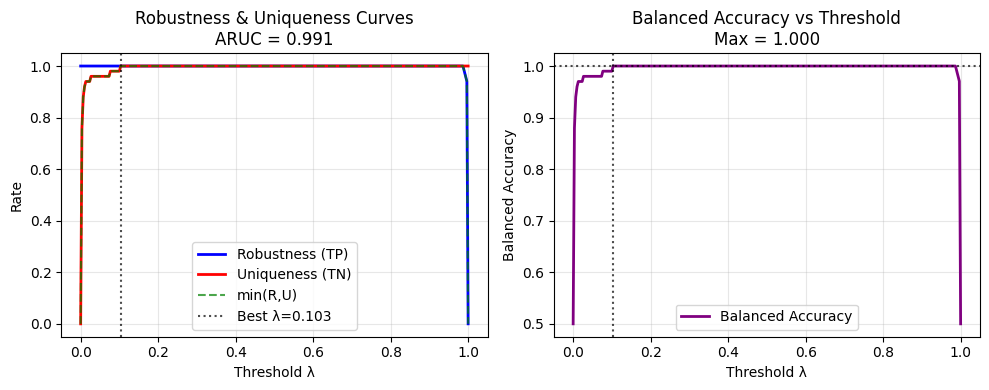

In [ ]:
# ==========================================================
#  Held-out verification (Robustness/Uniqueness/ARUC)
# ==========================================================
models_pos_te = [model_f.to(device)] + [m.to(device) for m in F_pos_te]
models_neg_te = [m.to(device) for m in F_neg_te]

@torch.no_grad()
def verify_scores_link(V, fp_set, models):
    """Get verification scores for test models"""
    Xs = [fp_set.concat_outputs(m, require_grad=False) for m in models]
    logits = V(torch.stack(Xs, dim=0).to(device))
    probs = F.softmax(logits, dim=-1)[:, 1]  # probability of being positive (pirated)
    return probs.detach().cpu().numpy()

print("🔍 Evaluating on test models...")
p_pos = verify_scores_link(V, fp_set, models_pos_te)
p_neg = verify_scores_link(V, fp_set, models_neg_te)

def sweep_threshold(p_pos, p_neg, num=301):
    """Sweep threshold to compute robustness/uniqueness curves"""
    ths = np.linspace(0.0, 1.0, num=num)
    R, U, A = [], [], []

    for t in ths:
        tp = (p_pos >= t).mean()    # robustness (true positive rate)
        tn = (p_neg < t).mean()     # uniqueness (true negative rate)
        R.append(tp)
        U.append(tn)
        A.append((tp + tn) / 2.0)   # balanced accuracy

    return ths, np.array(R), np.array(U), np.array(A)

# Compute metrics
ths, R, U, A = sweep_threshold(p_pos, p_neg, num=301)
best_idx = A.argmax()
mean_acc = A.mean()

# ARUC: Area under Robustness-Uniqueness curve
try:
    ARUC = np.trapezoid(np.minimum(R, U), ths)  # numpy >= 2.0
except AttributeError:
    ARUC = np.trapz(np.minimum(R, U), ths)      # numpy < 2.0

# Print results (compare with paper Table 1)
print("\n" + "="*60)
print("📊 FINAL RESULTS (Link Prediction on Cora)")
print("="*60)
print(f"Best @ λ={ths[best_idx]:.3f} | Robustness={R[best_idx]:.3f} | Uniqueness={U[best_idx]:.3f} | MeanAcc*={A[best_idx]:.3f}")
print(f"Mean Test Accuracy (avg over λ): {mean_acc:.3f}")
print(f"ARUC (Area under RU curve): {ARUC:.3f}")
print("\n📈 Paper comparison (Table 1 - Cora Link Prediction):")
print("   Paper GCN: ~0.838 | Paper GraphSAGE: ~0.823")
print("   Your Result: {:.3f}".format(A[best_idx]))
print("="*60)

# Optional: Plot curves if matplotlib available
try:
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(ths, R, 'b-', label='Robustness (TP)', linewidth=2)
    plt.plot(ths, U, 'r-', label='Uniqueness (TN)', linewidth=2)
    plt.plot(ths, np.minimum(R, U), 'g--', label='min(R,U)', alpha=0.7)
    plt.axvline(ths[best_idx], color='k', linestyle=':', alpha=0.7, label=f'Best λ={ths[best_idx]:.3f}')
    plt.xlabel('Threshold λ')
    plt.ylabel('Rate')
    plt.title(f'Robustness & Uniqueness Curves\nARUC = {ARUC:.3f}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(ths, A, 'purple', linewidth=2, label='Balanced Accuracy')
    plt.axvline(ths[best_idx], color='k', linestyle=':', alpha=0.7)
    plt.axhline(A[best_idx], color='k', linestyle=':', alpha=0.7)
    plt.xlabel('Threshold λ')
    plt.ylabel('Balanced Accuracy')
    plt.title(f'Balanced Accuracy vs Threshold\nMax = {A[best_idx]:.3f}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

except ImportError:
    print("📝 Install matplotlib for plots: !pip install matplotlib")
